In [ ]:
import numpy as np
import os
from guise import *

# Fingerprinting web pages

Say you had a list of web pages and you want to get a sense of what the website is about. 

You could scrape the words of that home pages and make word clouds from them.

You could also gather the internal (and possibly external) links on that home page, and scrape deeper (or wider). 

## Making a list

Of course, you could make the list manually, but you could also make the list from a page listing the items of interest to. 

Let's do that -- it's funner. 

### Making a list from a page containing the list

In [ ]:
import requests

list_url = 'https://nextgenvp.com/portfolio'
r = requests.get(list_url)
assert r.status_code == 200
html = r.content

In [ ]:
from bs4 import BeautifulSoup
b = BeautifulSoup(html)
bb = b.find(name='div', attrs={'class': 'row'})
company_snippets = bb.find_all(name='div', attrs={'class': 'd-flex'})
len(company_snippets)
company_snippets[0]

<div class="d-flex col-12 col-md-6 col-lg-4 col-xl-3 port-co healthcare">
<!-- Card -->
<div class="card mb-2 lift lift-lg pt-4">
<!-- Image -->
<a class="card-img-top m-auto" href="https://abett.com" style="min-height:80px;" target="_blank">
<!-- Image -->
<img alt="Abett" class="img-fluid card-img-top poco-logo center" src="https://cdn.nextgenvp.com/images/portfolio-logos/abett.png" style="max-width:100px;" title="Abett"/>
</a>
<!-- Body -->
<a class="card-body" href="https://abett.com" target="_blank">
<!-- Heading -->
<h4 class="text-center" style="min-height:60px;">
            Helps employers manage HR and healthcare benefits data                      </h4>
</a>
</div>
</div>

In [ ]:
from operator import itemgetter

def _rm_suffix_slash(x):
    if x[-1] == '/':
        return x[:-1]
    return x

def _extract_info(t):
    return dict(
        image_url=t.find(name='img').get('src'),
        homepage_url=_rm_suffix_slash(t.find(name='a', attrs={'class': "card-body"}).get('href')),
        short_description=t.find(name='h4').text.strip(),
    )

all_info = list(map(_extract_info, company_snippets))
all_info[0]

{'image_url': 'https://cdn.nextgenvp.com/images/portfolio-logos/abett.png',
 'homepage_url': 'https://abett.com',
 'short_description': 'Helps employers manage HR and healthcare benefits data'}

### Acquiring info out of these pages 

In [ ]:
from graze import Graze

rootdir = '/Users/Thor.Whalen/tmp/nextgenvp'
os.makedirs(rootdir, exist_ok=True)
htmls_dir = os.path.join(rootdir, 'html')
image_dir = os.path.join(rootdir, 'img')

htmls = Graze(htmls_dir)
_images = Graze(image_dir)

In [ ]:
def _fetch_responses(urls, html_store):
    for url in urls:
        try:
            yield url, html_store[url]  # note: Asking html_store for the contents of the url triggers the download if not already there.
        except Exception as e:
            print(f"Error ({e}) with {url}. Skipping")


In [ ]:
# To trigger the downloads if they haven't been already!
only_urls = list(map(itemgetter('homepage_url'), all_info))
# _ = dict(_fetch_responses(only_urls, htmls))

_ = dict(_fetch_responses(map(itemgetter('image_url'), all_info), _images))

In [ ]:
# To make an images store that uses the company url instead of the image url
from dol import ExplicitKeyMap, add_ipython_key_completions, wrap_kvs, Pipe
import io
from PIL import Image


trans = ExplicitKeyMap(key_of_id={d['image_url']: d['homepage_url'] for d in all_info})

images = wrap_kvs(
    _images,
    id_of_key=trans._id_of_key,
    key_of_id=trans._key_of_id,
    obj_of_data=Pipe(io.BytesIO, Image.open)
)
images = add_ipython_key_completions(images)
len(images)

59

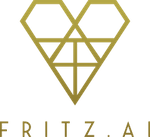

In [ ]:
images['http://fritz.ai']

In [ ]:
k, v = images.head()
print(k)

http://www.circulation.com


In [ ]:
from guise import html_tokens
from dol import wrap_kvs, Pipe
from operator import methodcaller

def _html_tokens(x):
    if toks := html_tokens(x):
        return toks
    return ['empty']

words = wrap_kvs(htmls, obj_of_data=Pipe(lambda x: x.decode(), _html_tokens, list))
word_cloud_images = wrap_kvs(words, obj_of_data=Pipe(word_cloud, methodcaller('to_image')))

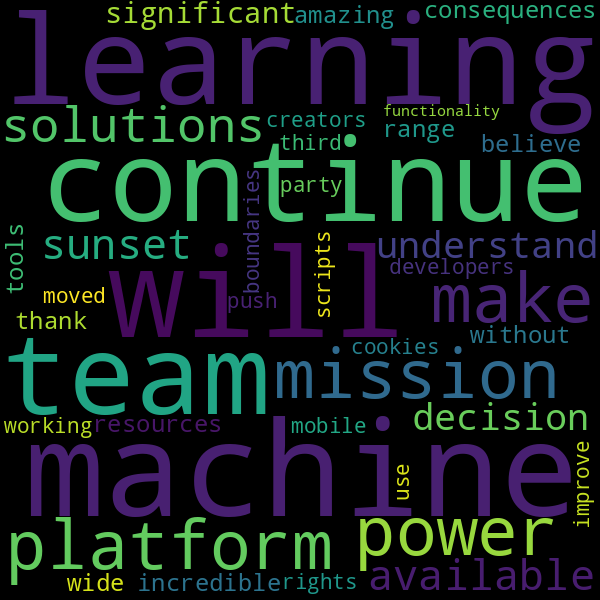

In [ ]:
word_cloud_images['http://fritz.ai']

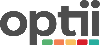

In [ ]:
def fit_image_to_width(image, width):
    original_size = image.size
    ratio = width / original_size[0]
    new_size = tuple([int(x * ratio) for x in original_size])
    return image.resize(new_size)

v = images['http://optiisolutions.com']
v = fit_image_to_width(v, 100)
v

In [ ]:
t = word_cloud_images['http://optiisolutions.com']
print(*dir(t))

_ArrayData _Image__transformer __array__ __class__ __copy__ __delattr__ __dict__ __dir__ __doc__ __enter__ __eq__ __exit__ __format__ __ge__ __getattr__ __getattribute__ __getstate__ __gt__ __hash__ __init__ __init_subclass__ __le__ __lt__ __module__ __ne__ __new__ __reduce__ __reduce_ex__ __repr__ __setattr__ __setstate__ __sizeof__ __str__ __subclasshook__ __weakref__ _category _close_exclusive_fp_after_loading _copy _crop _dump _ensure_mutable _exif _expand _get_safe_box _getxmp _new _repr_png_ _size alpha_composite close convert copy crop draft effect_spread entropy filter format format_description frombytes getbands getbbox getchannel getcolors getdata getexif getextrema getim getpalette getpixel getprojection height histogram im info load mode palette paste point putalpha putdata putpalette putpixel pyaccess quantize readonly reduce remap_palette resize rotate save seek show size split tell thumbnail tobitmap tobytes toqimage toqpixmap transform transpose verify width


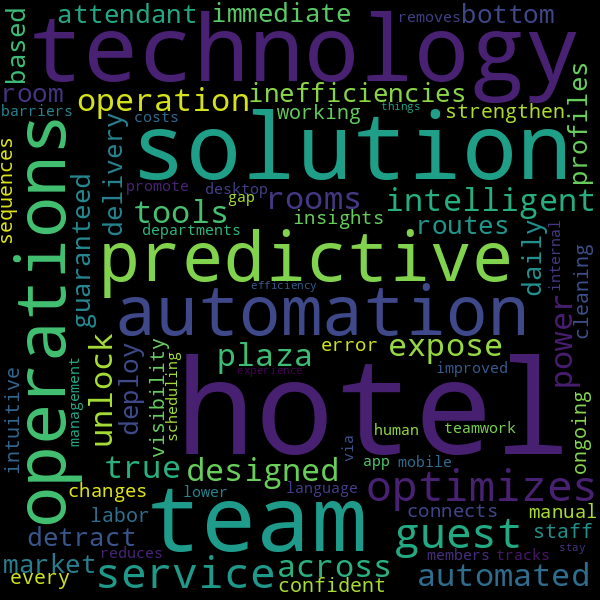

In [ ]:
mask = np.zeros(t.size + (3,))
mask[:100, :100] = 1
Image.fromarray(np.array(t))

In [ ]:
def _gen():
    for k in word_cloud_images:
        try:
            yield word_cloud_images[k]
        except Exception:
            print(f"Problem with {k}")
            pass
            
all_images = list(_gen())

Problem with https://docs.architect.io


In [ ]:
# del word_cloud_images['https://docs.architect.io']

### Make a pdf with the fingerprints

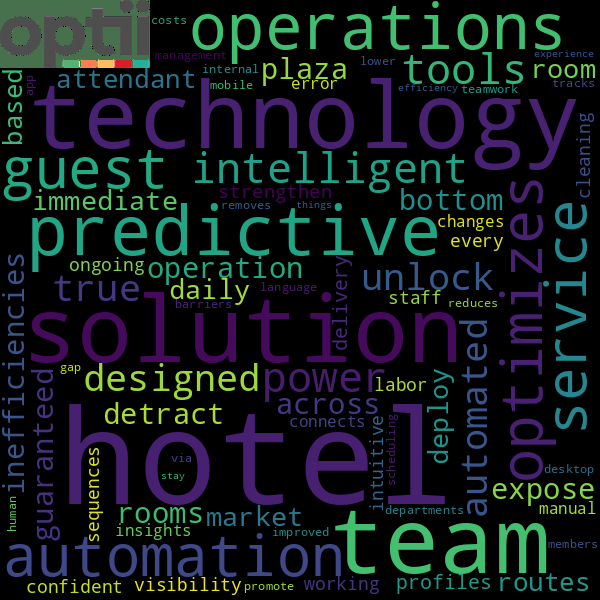

In [ ]:
def logo_and_word_cloud(
    url, logo_store=images, words_store=words, fit_width=150, image_store=word_cloud_images, width=600, height=600
):
    logo = logo_store[url]
    logo = fit_image_to_width(logo, fit_width)
    logo_height, logo_width = logo.size

    mask = np.zeros((width, height, 3))
    mask[:, :, :] = 0
    mask[:logo_width, :logo_height, :] = 255

#     Image.fromarray(mask)
    w = words[url]
    wc_image = word_cloud(w, mask=mask, width=width, height=height).to_image()
    wc_image.paste(logo)
    return wc_image

logo_and_word_cloud('http://optiisolutions.com')

In [ ]:
all_images = list(map(logo_and_word_cloud, words))

/Users/Thor.Whalen/.pyenv/versions/3.8.6/envs/p3/lib/python3.8/site-packages/wordcloud/wordcloud.py:996: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"
/Users/Thor.Whalen/.pyenv/versions/3.8.6/envs/p3/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
all_images[0].save("newgen_portfolio.pdf", "PDF", resolution=100.0, save_all=True, append_images=all_images[1:])

### Make splatter data

In [ ]:
from idiom import WordVec, WordVecStore  # pip install idiom

wv = WordVec()


In [ ]:
len(wv)

70982

In [ ]:
word_vecs = list(map(lambda word_list: np.array(list(filter(lambda x: x is not None, map(wv.get, word_list)))), words.values()))

In [ ]:
mean_vecs = {k: np.mean(v, axis=0) for k, v in zip(words, word_vecs)}
mean_vecs_mat = np.array(list(mean_vecs.values()))

In [ ]:
from pathlib import Path
Path('mean_word_vectors.tsv').write_text('\n'.join(map(lambda row: '\t'.join(map(str, row)), mean_vecs_mat)))

302682

In [ ]:
mean_vecs = {k: np.mean(v, axis=0) for k, v in zip(words, word_vecs)}
mean_vecs_mat = np.array(list(mean_vecs.values()))

from pathlib import Path

Path('all_word_vectors.tsv').write_text('\n'.join(map(lambda row: '\t'.join(map(str, row)), np.vstack(word_vecs))))

13578467

# Behind the scenes: The tools we used, and you can use too

How did we get from query term to a semantic fingerprint of the word?

By gathering a bunch of related words. 

Namely, with `google_results_toks`, what we did was did Google search, 
harvested the urls it gave, then went and fetched the first page of each one of those, 
and extracted words from them. 
We'll now show these steps to demo the functions we used: 
They might be useful by themselves, and you may want to edit this pipeline to get 
exactly what you're looking for.

Note that there are other ways to gather related words, like using `word2vec` similarity, 
or specifically purposed DBs, etc.

In [ ]:
from functools import partial
from itertools import chain
from collections import Counter 
from guise import map_words_of_word_count

from guise import *
len(DFLT_EXCLUDE_TERMS)

193

In [ ]:
q = "cute kittens"
num = 30  # number of results to ask for
lr = 'lang_en'  # language filter (see https://developers.google.com/custom-search/v1/reference/rest/v1/cse/list)
include = DFLT_INCLUDE_TERMS  # default is English's 100K most frequent words
exclude = DFLT_EXCLUDE_TERMS  # default is a set of 193 english stopwords
verbose = True  # should we print the problematic urls?

# get the google results html for query q
results_html = google_search_html(q, num=num, lr=lr)

# parse out the results urls
results_urls = google_results_urls(results_html)

# get the landing page (html) of each one of those result urls
htmls = [url_to_html(url) for url in results_urls]

# make a list of urls whose htmls couldn't be acquired
# (status_code>200, or other kind of problem)
problematic_urls = [results_urls[i] for i, html in enumerate(htmls) if html is None]

# filter out the "bad" results
htmls = list(filter(None, htmls))
if problematic_urls and verbose:
    print('There were some problematic urls:')
    print(*problematic_urls, sep='\n')

# get an iterator of tokens (words/terms) extracted from these htmls
tokenizer = partial(html_tokens, include=include, exclude=exclude)
tokens = list(chain.from_iterable(map(tokenizer, htmls)))

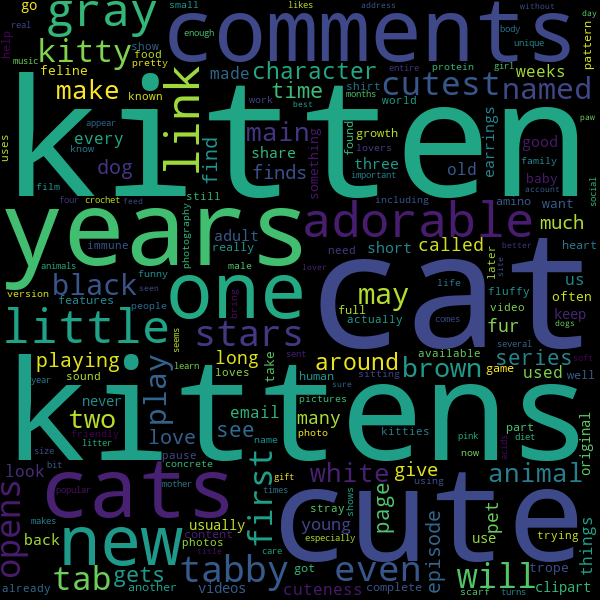

In [ ]:
word_cloud(tokens).to_image()

We see that a lot of words that have the same stem, so let's group these...

Before stem-grouping: 3016 unique words
After stem-grouping: 2046 unique words


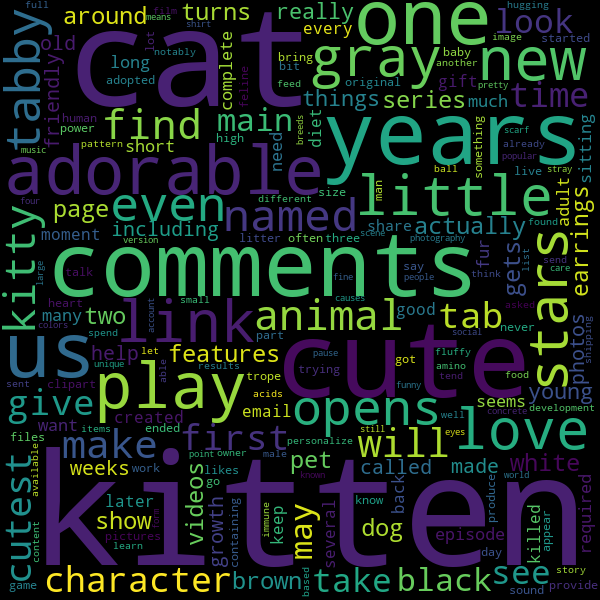

In [ ]:
word_count = Counter(tokens)
print(f"Before stem-grouping: {len(word_count)} unique words")
word_map = stem_based_word_mapping(word_count)
word_count = map_words_of_word_count(word_count, word_map)
print(f"After stem-grouping: {len(word_count)} unique words")

word_cloud(word_count).to_image()  # Note: we're feeding the word_count now!

2021-12-07 13:42:28,385 loading file /Users/Thor.Whalen/.flair/models/sentiment-en-mix-distillbert_4.pt


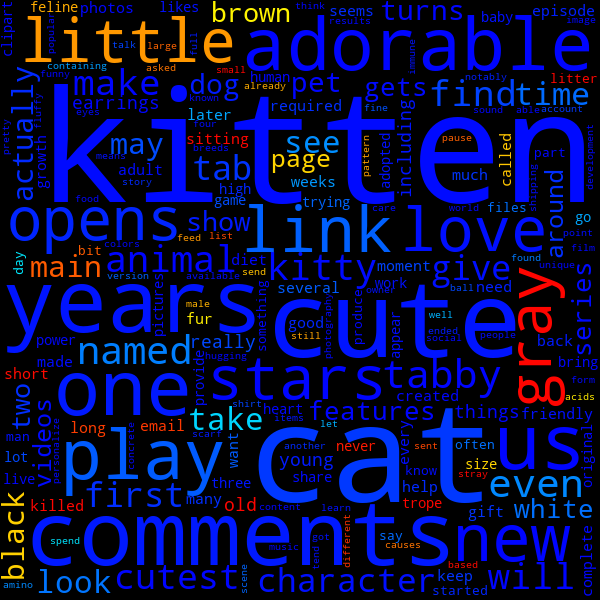

In [ ]:
sentiment_color = mk_word_score_base_color_func()  # requires flair to be installed
word_cloud(word_count, color_func=sentiment_color).to_image()

In [ ]:
from guise import google_results_toks, word_cloud

ERROR with https://www.vdh.virginia.gov/coronavirus/: HTTPSConnectionPool(host='www.vdh.virginia.gov', port=443): Max retries exceeded with url: /coronavirus/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1124)')))
There were some problematic urls:
https://www.worldometers.info/coronavirus/%3Futm_campaign%3DhomeAdvegas1%3F
https://www.vdh.virginia.gov/coronavirus/
https://jamanetwork.com/journals/jama/pages/coronavirus-alert


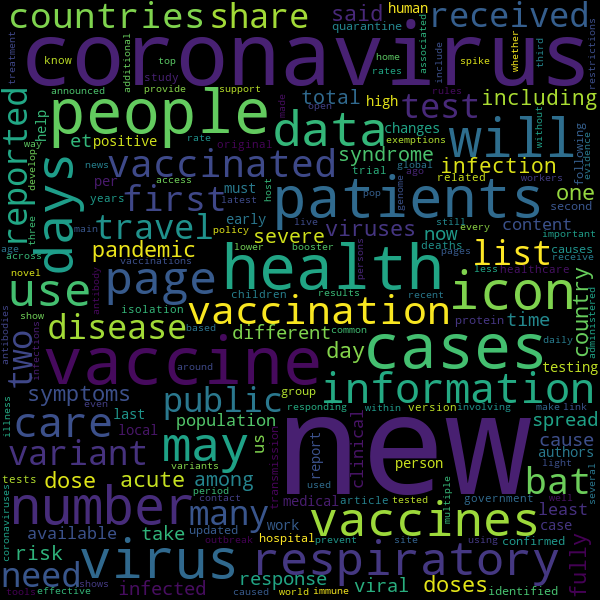

In [ ]:
words = list(google_results_toks('Coronavirus'))
wc = word_cloud(words)
wc.to_image()

The size of words is correlated with the word count, or more generally, word weight. 

The `word_cloud` function does this for you, but you could also specify the actual word count you want to use 
by entering a `{word: weight, ...}` dict of your own. 

For example, the following computes word counts, but uses "stemming" to reduce the number of unique words by 
using the same word when these words have the same "stem" (e.g. 'vaccinated'->'vaccine'). 

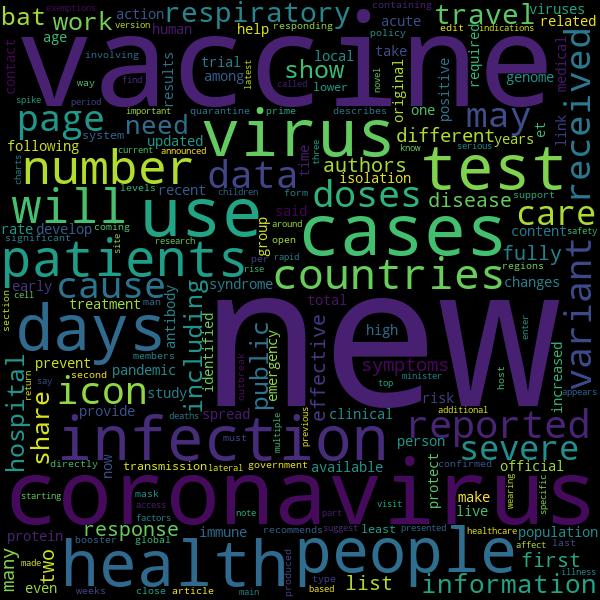

In [ ]:
from guise import stem_based_word_count
word_count = stem_based_word_count(words)
word_cloud(word_count).to_image()

We could use the same words, but choose to color the words with their sentiment score, 
with shades from red (negative) to blue (positive).

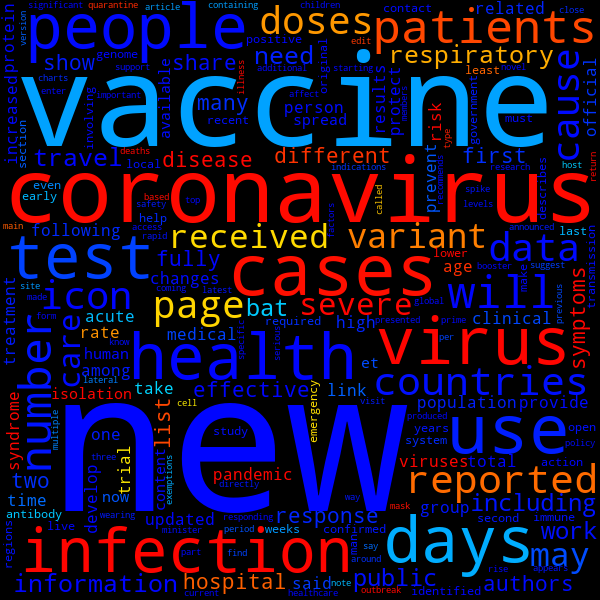

In [ ]:
sentiment_color = mk_word_score_base_color_func()  # requires flair to be installed
word_cloud(word_count, color_func=sentiment_color).to_image()